#M5_Forecasting 'Sale promotion analysis'
Discounts are meant to 


In [1]:
import pandas as pd
import databricks.koalas as ks
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib import gridspec
import numpy as np

In [2]:
calendar=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/calendar.csv')
sales_train_val=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/sales_train_validation.csv',dtype={f'd_{v}':'int8' for v in range(1,1914)})
sell_prices=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/sell_prices.csv')

In [3]:
sell_prices['item_id'] = sell_prices['item_id'] + '_' + sell_prices['store_id']

In [4]:
%%time

highiest_price = sell_prices.drop(columns=['store_id','wm_yr_wk']).groupby('item_id').quantile(0.95).rename(columns={'sell_price':'highiest_price'}).reset_index()
lowest_price = sell_prices.drop(columns=['store_id','wm_yr_wk']).groupby('item_id').quantile(0.05).rename(columns={'sell_price':'lowest_price'}).reset_index()

CPU times: user 1.79 s, sys: 165 ms, total: 1.96 s
Wall time: 1.97 s


In [5]:
sell_prices = pd.merge(sell_prices,highiest_price,on='item_id')
sell_prices = pd.merge(sell_prices,lowest_price,on='item_id')

In [6]:
sell_prices['discount'] = ( sell_prices['highiest_price'] - sell_prices['lowest_price'] ) / sell_prices['highiest_price']

In [7]:
sell_prices.drop(columns='store_id',inplace=True)

In [8]:
sell_prices.head()

,item_id,wm_yr_wk,sell_price,highiest_price,lowest_price,discount
0,HOBBIES_1_001_CA_1,11325,9.58,8.38,8.26,0.01432
1,HOBBIES_1_001_CA_1,11326,9.58,8.38,8.26,0.01432
2,HOBBIES_1_001_CA_1,11327,8.26,8.38,8.26,0.01432
3,HOBBIES_1_001_CA_1,11328,8.26,8.38,8.26,0.01432
4,HOBBIES_1_001_CA_1,11329,8.26,8.38,8.26,0.01432


In [9]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
sales_train_val.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [11]:
sales_train_val['id']=sales_train_val['id'].str[:-11]

In [12]:
sdf = sales_train_val.drop(columns=['item_id','dept_id','cat_id','store_id','state_id']).set_index('id').T
sdf = sdf.reset_index().rename(columns={'index':'d'})
sdf = pd.merge(left=sdf,right=calendar[['d','wm_yr_wk']],on='d').groupby('wm_yr_wk').sum().reset_index()

In [13]:
sdf.head(3)

,wm_yr_wk,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,11101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,17.0,...,0.0,72.0,8.0,0.0,32.0,8.0,5.0,15.0,0.0,0.0
1,11102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,17.0,...,0.0,83.0,20.0,0.0,29.0,16.0,11.0,35.0,0.0,0.0
2,11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,...,0.0,84.0,19.0,0.0,35.0,10.0,7.0,55.0,0.0,0.0


In [14]:
def salesDF(column):
    ''' create temporary DataFrame with item_id, wm_yr_wk, sales values '''
    df = sdf[[column,'wm_yr_wk']].rename(columns = {column:'sales'})
    df['item_id'] = column
    return df

In [15]:
sales_df = pd.concat( [salesDF(c) for c in tqdm(sdf.columns[1:])] )

100%|██████████| 30490/30490 [00:50<00:00, 605.89it/s]


In [16]:
sell_prices.head()

,item_id,wm_yr_wk,sell_price,highiest_price,lowest_price,discount
0,HOBBIES_1_001_CA_1,11325,9.58,8.38,8.26,0.01432
1,HOBBIES_1_001_CA_1,11326,9.58,8.38,8.26,0.01432
2,HOBBIES_1_001_CA_1,11327,8.26,8.38,8.26,0.01432
3,HOBBIES_1_001_CA_1,11328,8.26,8.38,8.26,0.01432
4,HOBBIES_1_001_CA_1,11329,8.26,8.38,8.26,0.01432


In [17]:
%%time
df = pd.merge(left=sales_df,right=sell_prices,on=['item_id','wm_yr_wk'])
df['revenue'] = df['sales'] * df['sell_price']

CPU times: user 2.15 s, sys: 900 ms, total: 3.05 s
Wall time: 3.05 s


In [18]:
df['revenue_per_week'] = df['revenue'] / 7

In [19]:
df.sort_values(by=['discount','revenue_per_week'])

,sales,wm_yr_wk,item_id,sell_price,highiest_price,lowest_price,discount,revenue,revenue_per_week
1802138,-447.0,11229,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-2226.06,-318.008571
1802137,-257.0,11228,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-1279.86,-182.837143
1802145,-218.0,11236,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-1085.64,-155.091429
1802296,-185.0,11530,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-921.30,-131.614286
3808438,-108.0,11546,FOODS_3_120_TX_2,4.98,4.98,4.98,0.000000,-537.84,-76.834286
...,...,...,...,...,...,...,...,...,...
3986381,7.0,11224,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,17.99,2.570000
3986384,7.0,11227,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,17.99,2.570000
3986352,8.0,11147,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,20.56,2.937143
3986369,8.0,11212,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,20.56,2.937143


In [20]:
%%time
df.sort_values('discount',ascending=False)\
    .loc[ \
        (df['sell_price'] != df['highiest_price']) &\
        (df['sales'] > 0) &\
        (df['discount'] > 0)]\
    .sort_values('item_id')\
    .groupby('item_id','')

ValueError: No axis named  for object type <class 'pandas.core.frame.DataFrame'>

In [21]:
df.groupby('item_id').mean()[['discount']].sort_values('discount',ascending=False).head(20)

,discount
item_id,
HOBBIES_1_106_TX_3,0.902724
HOUSEHOLD_2_080_TX_3,0.888641
FOODS_3_296_TX_3,0.875000
HOUSEHOLD_2_466_TX_1,0.845134
FOODS_2_348_TX_3,0.832776
FOODS_1_126_TX_3,0.813433
FOODS_1_029_TX_3,0.765808
FOODS_2_329_TX_3,0.763593
HOBBIES_1_114_TX_2,0.748744


In [22]:
df.head(3)

,sales,wm_yr_wk,item_id,sell_price,highiest_price,lowest_price,discount,revenue,revenue_per_week
0,1.0,11325,HOBBIES_1_001_CA_1,9.58,8.38,8.26,0.01432,9.58,1.368571
1,0.0,11326,HOBBIES_1_001_CA_1,9.58,8.38,8.26,0.01432,0.00,0.000000
2,2.0,11327,HOBBIES_1_001_CA_1,8.26,8.38,8.26,0.01432,16.52,2.360000


In [23]:
sales_per_price = df[['item_id','sell_price','sales']].groupby(['item_id','sell_price']).agg({'sales':['count','sum']})['sales'].reset_index(level=1).reset_index()

sales_per_price['per_period'] = ( sales_per_price['sum'] * sales_per_price['sell_price'] ) / sales_per_price['count']
sales_per_price.drop(columns=['count','sum'],inplace=True)
sales_per_price

,item_id,sell_price,per_period
0,FOODS_1_001_CA_1,2.00,13.879518
1,FOODS_1_001_CA_1,2.24,10.871623
2,FOODS_1_001_CA_2,2.00,21.228916
3,FOODS_1_001_CA_2,2.24,15.633089
4,FOODS_1_001_CA_3,1.75,3.500000
...,...,...,...
83482,HOUSEHOLD_2_516_TX_2,5.94,10.263971
83483,HOUSEHOLD_2_516_TX_3,5.94,5.072847
83484,HOUSEHOLD_2_516_WI_1,5.94,3.598686
83485,HOUSEHOLD_2_516_WI_2,5.94,1.369071


In [24]:
df = pd.merge(left=df,right=sales_per_price,on=['item_id','sell_price'])

In [25]:
pd.Categorical(df['item_id'])

[HOBBIES_1_001_CA_1, HOBBIES_1_001_CA_1, HOBBIES_1_001_CA_1, HOBBIES_1_001_CA_1, HOBBIES_1_001_CA_1, ..., FOODS_3_827_WI_3, FOODS_3_827_WI_3, FOODS_3_827_WI_3, FOODS_3_827_WI_3, FOODS_3_827_WI_3]
Length: 6597201
Categories (30490, object): [FOODS_1_001_CA_1, FOODS_1_001_CA_2, FOODS_1_001_CA_3, FOODS_1_001_CA_4, ..., HOUSEHOLD_2_516_TX_3, HOUSEHOLD_2_516_WI_1, HOUSEHOLD_2_516_WI_2, HOUSEHOLD_2_516_WI_3]

In [26]:
%%time
df.loc[(df['discount']>0) & (df['revenue']>0)].groupby(['item_id','sell_price']).agg({'per_period':'mean','sales':'sum','highiest_price':'max','lowest_price':'min'}).assign(dscnt=lambda x: pd.Categorical(x['lowest_price']) if True else 6)

CPU times: user 819 ms, sys: 457 ms, total: 1.28 s
Wall time: 1.29 s


per_period   sales  highiest_price  \
item_id              sell_price                                       
FOODS_1_001_CA_1     2.00         13.879518   576.0            2.24   
                     2.24         10.871623   927.0            2.24   
FOODS_1_001_CA_2     2.00         21.228916   881.0            2.24   
                     2.24         15.633089  1333.0            2.24   
FOODS_1_001_CA_3     1.75          3.500000     2.0            2.24   
...                                     ...     ...             ...   
HOUSEHOLD_2_514_WI_2 20.97         3.994286     4.0           20.97   
HOUSEHOLD_2_514_WI_3 17.94        10.321644    42.0           19.54   
                     18.47         6.156667     7.0           19.54   
                     18.97        20.404706   128.0           19.54   
                     19.54         9.609836    30.0           19.54   

                                 lowest_price  dscnt  
item_id              sell_price                       
FOODS_1_001_CA_1     2.00                2.00   2.00  
                     2.24                2.00   2.00  
FOODS_1_001_CA_2     2.00                2.00   2.00  
                     2.24                2.00   2.00  
FOODS_1_001_CA_3     1.75                2.00   2.00  
...                                       ...    ...  
HOUSEHOLD_2_514_WI_2 20.97              17.94  17.94  
HOUSEHOLD_2_514_WI_3 17.94              17.94  17.94  
                     18.47              17.94  17.94  
                     18.97              17.94  17.94  
                     19.54              17.94  17.94  

[70251 rows x 5 columns]

In [27]:
df.loc[(df['discount']>0) & (df['revenue']>0)].groupby(['item_id','sell_price']).agg({'sales':'sum'}).groupby('item_id').agg({'sales':'max'})

,sales
item_id,
FOODS_1_001_CA_1,927.0
FOODS_1_001_CA_2,1333.0
FOODS_1_001_CA_3,1386.0
FOODS_1_001_CA_4,433.0
FOODS_1_001_TX_1,716.0
...,...
HOUSEHOLD_2_514_TX_2,244.0
HOUSEHOLD_2_514_TX_3,118.0
HOUSEHOLD_2_514_WI_1,148.0


In [28]:
%%time
df.loc[(df['discount']>0) & (df['revenue']>0)]\
    .groupby(['item_id','sell_price'])\
    .agg({'per_period':'mean','sales':'sum','highiest_price':'max','lowest_price':'min'})\
    .merge(right = df.loc[(df['discount']>0) & (df['revenue']>0)]\
                        .groupby(['item_id','sell_price'])\
                        .agg({'sales':'sum'})\
                        .groupby('item_id')\
                        .agg({'sales':'max'})\
                        .rename(columns={'sales':'sales_max'}),
                    left_index=True,right_index=True
    )\
    .sort_values(['item_id','sales'],ascending=False)\
    .reset_index(level=1)\
    .groupby(['item_id']).first()\
    .reset_index()\
    .loc[df.sales == df.lowest_price]\
    .assign(discount=lambda x: (x.highiest_price - x.lowest_price)/ x.highiest_price)\
    .sort_values('discount',ascending=False)
    


CPU times: user 1.35 s, sys: 581 ms, total: 1.93 s
Wall time: 1.94 s


,item_id,sell_price,per_period,sales,highiest_price,lowest_price,sales_max,discount
15075,HOUSEHOLD_1_189_CA_1,5.88,9.576000,114.0,5.88,4.97,114.0,0.154762
16656,HOUSEHOLD_1_452_TX_2,3.47,10.955026,603.0,3.47,2.97,603.0,0.144092
14973,HOUSEHOLD_1_177_CA_2,7.97,197.293727,2723.0,7.97,6.97,2723.0,0.125471
15100,HOUSEHOLD_1_191_TX_2,2.96,83.909565,1956.0,3.38,2.96,1956.0,0.124260
15099,HOUSEHOLD_1_191_TX_1,3.38,48.728333,1903.0,3.38,2.96,1903.0,0.124260
16531,HOUSEHOLD_1_437_CA_2,3.38,39.177273,1530.0,3.38,2.96,1530.0,0.124260
16437,HOUSEHOLD_1_421_TX_1,5.98,18.131360,379.0,6.64,5.88,379.0,0.114458
15028,HOUSEHOLD_1_182_WI_2,3.97,17.922536,623.0,4.47,3.97,623.0,0.111857
14957,HOUSEHOLD_1_175_TX_2,4.87,30.128294,1559.0,4.87,4.50,1559.0,0.075975
15017,HOUSEHOLD_1_181_WI_1,3.94,34.537872,824.0,4.23,3.92,824.0,0.073286


In [29]:
to_discounted_items = df.groupby('item_id').mean()[['discount']].sort_values('discount',ascending=False).head(20).index

In [30]:
def plot_discount_level(df_plot):
    my_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_values = my_scaler.fit_transform(df_plot[['sell_price']])
    processed_value = scaled_values[0][0]
    start_iN = 0
    values_list = []
    for v in range(len(scaled_values)):
        if scaled_values[v][0] != processed_value:
            values_list.append((start_iN,v,scaled_values[v-1][0]))
            start_iN = v
            processed_value = scaled_values[v][0]
    #add last value        
    values_list.append((start_iN,v,scaled_values[v][0]))
    for v in values_list:
        #plt.axvspan(v[0],v[1],alpha=v[2]*0.3,ymin=0,ymax=30,facecolor='#FBFCEE')
        plt.axvspan(v[0],v[1],alpha=v[2]*0.6,ymin=0,ymax=30,facecolor='black')
    return values_list


In [156]:
def plot_sales_vs_discount(c):
    plt.figure(figsize=[25,9])

    gs = gridspec.GridSpec(2, 2, width_ratios=[19,1],height_ratios=[19,5]) 
    gs.update(hspace=0.2,wspace=0.03)
    df_plot = df.loc[df['item_id'] == c].reset_index(drop=True)
    lenght = df_plot.shape[0]


    #sales
    plt.subplot(gs[0])
    plt.title(f'sales of {c} ',fontdict={'size':20})
    plt.xlim(0,lenght)
    plt.ylim(0,df_plot['sales'].max()*1.1)

    plt.plot(df_plot['sales'],label='sales',color='#FBFCEE',linewidth=3)
    
    

    plot_discount_level(df_plot)
    plt.gca().set_facecolor('#05668D')
    
    plt.legend()

    #legend
    plt.subplot(gs[1])
    plot_color_range(c)

    #price
    plt.subplot(gs[2])
    plt.xlim(0,lenght)
    plt.ylim(-0.2,1.2)
    plt.gca().set_facecolor('#05668D')
    plt.title('price vs weekly sales',fontdict={'size':15})

    my_scaler = MinMaxScaler(feature_range=(0,1))

    plt.plot(my_scaler.fit_transform(df_plot[['sell_price']]),color='#FBFCEE',linewidth=3,label='price')
    plt.gca().get_xaxis().set_visible(False)

    #AVG weekly sales
    
    plt.plot(my_scaler.fit_transform(df_plot[['per_period']]),color='#02C39A',linewidth=3,label='avg weekly sales',alpha=0.9)
    plt.legend()

    
    
    plot_discount_level(df_plot)



In [157]:
def create_yticks(max_value,min_value):
    y_labels = np.arange(min_value,max_value,(max_value-min_value)/5) 
    return list(y_labels.round(2)) + [max_value]

In [158]:
def plot_color_range(c):
    df_plot = df.loc[df['item_id'] == c].reset_index(drop=True)
    
    max_v = df_plot['sell_price'].max()
    min_v = df_plot['sell_price'].min()
    plt.gca().set_facecolor('#05668D')
    plt.ylim(0,1)
    for n in (np.arange(1,0,-0.1)).round(2):
        plt.axhspan(ymin=n,ymax=max_v,alpha=n*0.25,color='black')
    y_tick_labels = create_yticks(max_v,min_v)
    
    plt.gca().set_yticklabels(y_tick_labels)
    plt.gca().yaxis.tick_right()
    plt.gca().get_xaxis().set_visible(False)

In [156]:
df.loc[df['item_id']=='HOUSEHOLD_1_191_TX_2']['sell_price'].sort_values().unique()

array([2.96, 3.28, 3.38])

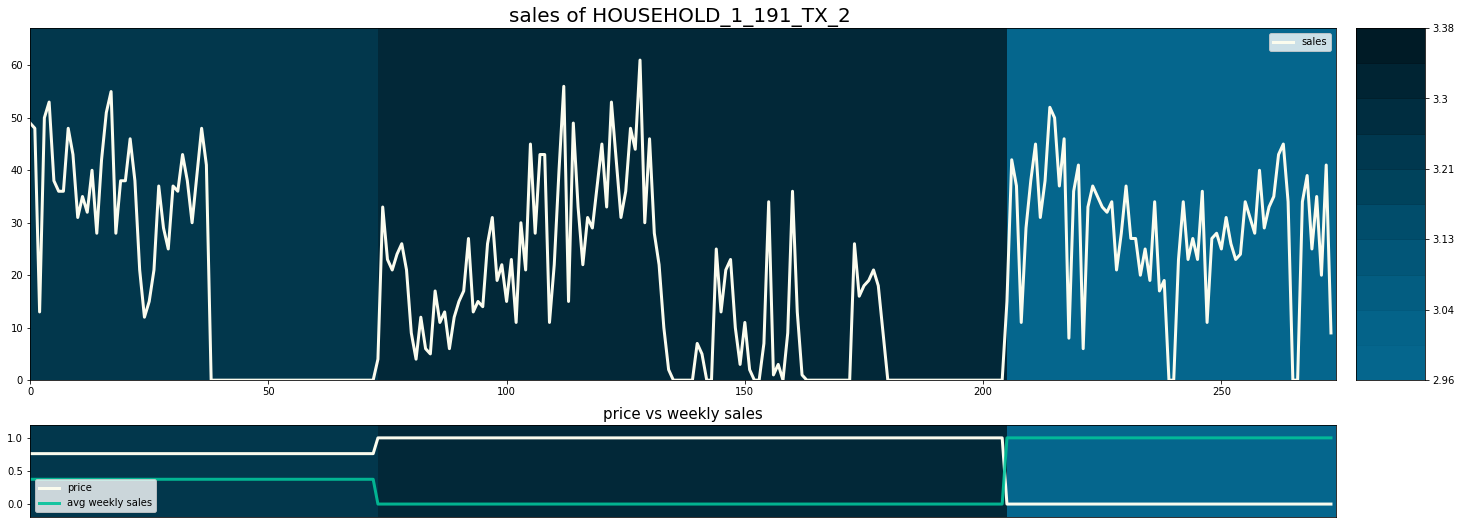

In [159]:
plot_sales_vs_discount('HOUSEHOLD_1_191_TX_2')
plt.show()

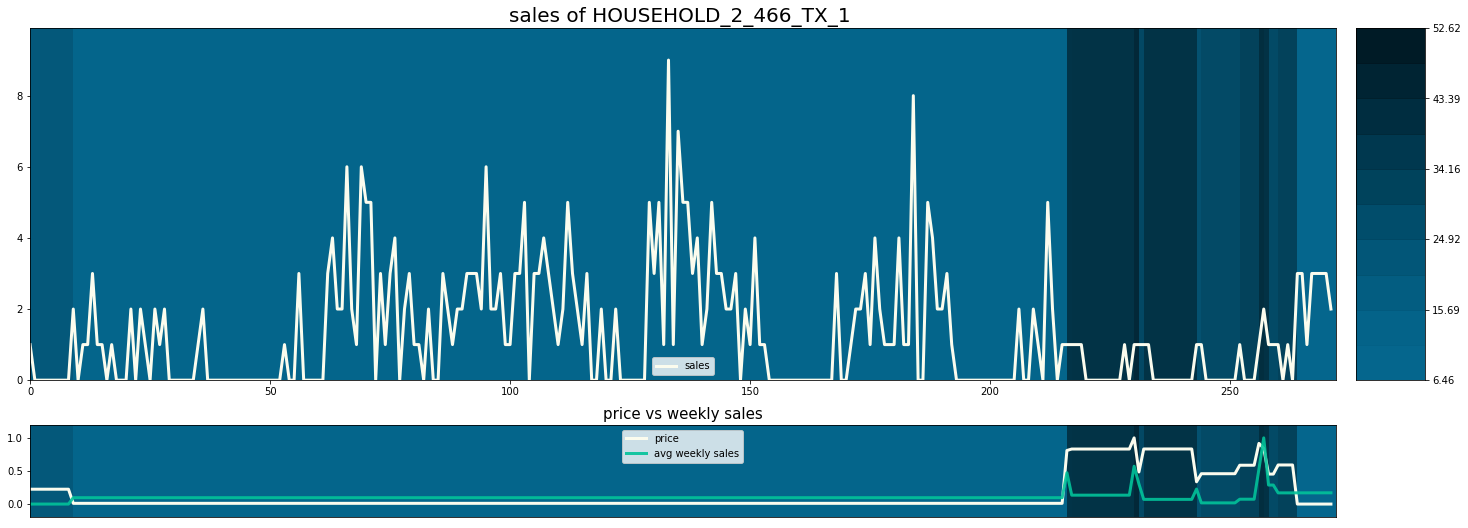

In [161]:
plot_sales_vs_discount('HOUSEHOLD_2_466_TX_1')
plt.show()

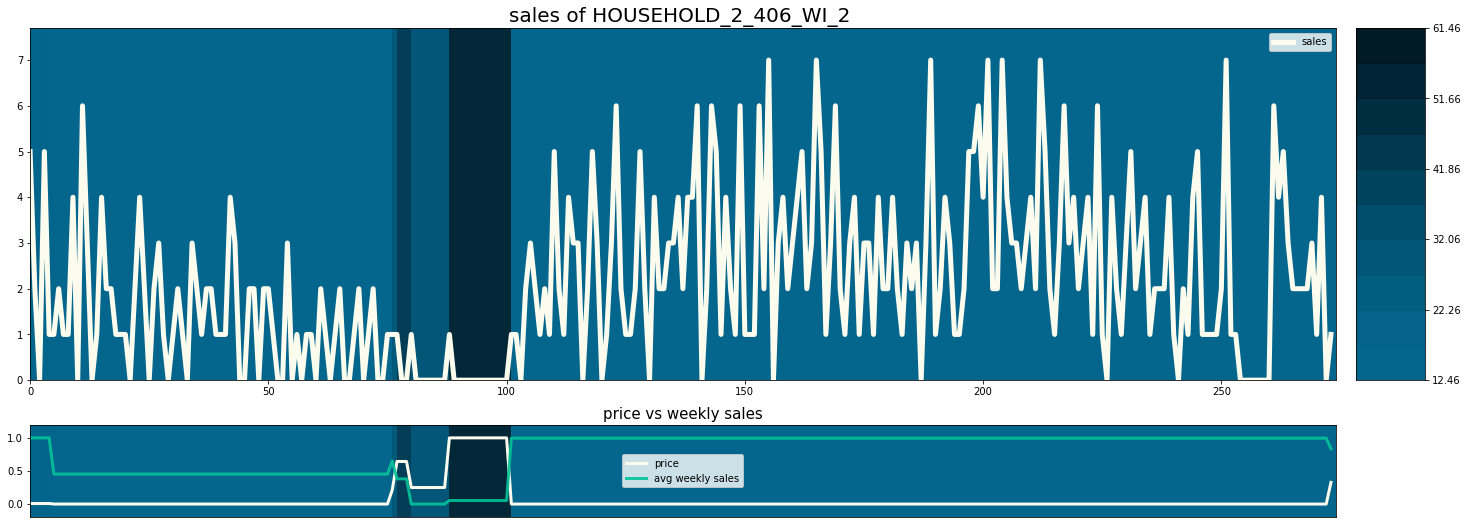

In [154]:
plot_sales_vs_discount('HOUSEHOLD_2_406_WI_2')
plt.show()

In [155]:

plots = len(top_discounted_items)
plt.figure(figsize=[25,7*plots])

for c in tqdm(top_discounted_items):
    plot_sales_vs_discount(c)
plt.show()

NameError: name 'top_discounted_items' is not defined